## Imports and Load + Split Data

In [32]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import os


train_dataset = datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([      
                transforms.ToTensor(),           
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

def train_valid_split(train_dataset, fraction):
    np.random.random(148)
    
    all_indices = list(range(len(train_dataset)))
    np.random.shuffle(all_indices)
    all_indices = all_indices[:int(len(all_indices)*fraction)]
    
    digits = {}
    for i in all_indices:
        label = train_dataset[i][1]
        if label in digits:
            digits[label].append(i)
        else:
            digits[label] = [i]
    
    subset_indices_train = []
    subset_indices_valid = []
    
    for digit in digits:
        indices = digits[digit]
        total = len(indices)
        np.random.shuffle(indices)
        subset_indices_valid.extend(indices[:int(0.15*total)])
        subset_indices_train.extend(indices[int(0.15*total):int(total)])

    assert(len(subset_indices_train) + len(subset_indices_valid) == len(all_indices))
    return subset_indices_train, subset_indices_valid


class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.norm = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.15)
        self.dropout2 = nn.Dropout2d(0.15)
        self.fc1 = nn.Linear(1600, 64)
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output
    
    
def train(model, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()  
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()               
        output = model(data)              
        loss = F.nll_loss(output, target) 
        losses.append(loss.item())
        loss.backward()                  
        optimizer.step()                   
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item()))     
    return np.average(losses)


def test(model, test_loader):
    model.eval()    
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad(): 
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)
    test_loss /= test_num
    print('\nAccuracy: {}/{} ({:.0f}%)\n'.format( correct, test_num, 100. * correct / test_num))
    return (100. * correct / test_num)
    

In [33]:
subsets = [0.0625, 0.125, 0.25, 0.5, 1]

training_losses = []
valid_losses = []
training_errors = []
test_errors = []

for fraction in subsets:
    subset_indices_train, subset_indices_valid = train_valid_split(train_dataset, fraction)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64,
        sampler=SubsetRandomSampler(subset_indices_train)
    )
    val_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64,
        sampler=SubsetRandomSampler(subset_indices_valid)
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=True)
    
    model = Net()
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    train_loss = []
    valid_loss = []
    epochs = 14
    for epoch in range(1, epochs + 1):
        train_loss.append(train(model, train_loader, optimizer, epoch))
        valid_loss.append(test(model, val_loader))
        scheduler.step() 

    print("Training Set ({} Subset):".format(str(fraction)))
    train_error = test(model, train_loader)
    print("Test Set ({} Subset):".format(str(fraction)))
    test_error = test(model, test_loader)
    
    training_errors.append(train_error)
    test_errors.append(test_error)
    training_losses.append(train_loss)
    valid_losses.append(valid_loss)

    torch.save(model.state_dict(), "best_MNIST_Net_{}.pt".format(str(fraction)))

Train Epoch: 1 [0/3193 (0%)]	Loss: 2.303875
Train Epoch: 1 [640/3193 (20%)]	Loss: 1.569728
Train Epoch: 1 [1280/3193 (40%)]	Loss: 0.726305
Train Epoch: 1 [1920/3193 (60%)]	Loss: 0.332205
Train Epoch: 1 [2560/3193 (80%)]	Loss: 0.244924

Accuracy: 526/557 (94%)

Train Epoch: 2 [0/3193 (0%)]	Loss: 0.219154
Train Epoch: 2 [640/3193 (20%)]	Loss: 0.152044
Train Epoch: 2 [1280/3193 (40%)]	Loss: 0.114814
Train Epoch: 2 [1920/3193 (60%)]	Loss: 0.113548
Train Epoch: 2 [2560/3193 (80%)]	Loss: 0.103220

Accuracy: 533/557 (96%)

Train Epoch: 3 [0/3193 (0%)]	Loss: 0.210291
Train Epoch: 3 [640/3193 (20%)]	Loss: 0.062535
Train Epoch: 3 [1280/3193 (40%)]	Loss: 0.089011
Train Epoch: 3 [1920/3193 (60%)]	Loss: 0.082199
Train Epoch: 3 [2560/3193 (80%)]	Loss: 0.115746

Accuracy: 537/557 (96%)

Train Epoch: 4 [0/3193 (0%)]	Loss: 0.132556
Train Epoch: 4 [640/3193 (20%)]	Loss: 0.075691
Train Epoch: 4 [1280/3193 (40%)]	Loss: 0.061648
Train Epoch: 4 [1920/3193 (60%)]	Loss: 0.046253
Train Epoch: 4 [2560/3193 (80%

Train Epoch: 9 [5120/6379 (80%)]	Loss: 0.003371
Train Epoch: 9 [5760/6379 (90%)]	Loss: 0.083950

Accuracy: 1107/1121 (99%)

Train Epoch: 10 [0/6379 (0%)]	Loss: 0.015818
Train Epoch: 10 [640/6379 (10%)]	Loss: 0.007584
Train Epoch: 10 [1280/6379 (20%)]	Loss: 0.011706
Train Epoch: 10 [1920/6379 (30%)]	Loss: 0.037078
Train Epoch: 10 [2560/6379 (40%)]	Loss: 0.004785
Train Epoch: 10 [3200/6379 (50%)]	Loss: 0.035276
Train Epoch: 10 [3840/6379 (60%)]	Loss: 0.028904
Train Epoch: 10 [4480/6379 (70%)]	Loss: 0.009031
Train Epoch: 10 [5120/6379 (80%)]	Loss: 0.011344
Train Epoch: 10 [5760/6379 (90%)]	Loss: 0.000825

Accuracy: 1107/1121 (99%)

Train Epoch: 11 [0/6379 (0%)]	Loss: 0.022620
Train Epoch: 11 [640/6379 (10%)]	Loss: 0.008113
Train Epoch: 11 [1280/6379 (20%)]	Loss: 0.007431
Train Epoch: 11 [1920/6379 (30%)]	Loss: 0.003399
Train Epoch: 11 [2560/6379 (40%)]	Loss: 0.002121
Train Epoch: 11 [3200/6379 (50%)]	Loss: 0.012824
Train Epoch: 11 [3840/6379 (60%)]	Loss: 0.007333
Train Epoch: 11 [4480/637

Train Epoch: 6 [5120/12754 (40%)]	Loss: 0.017681
Train Epoch: 6 [5760/12754 (45%)]	Loss: 0.029273
Train Epoch: 6 [6400/12754 (50%)]	Loss: 0.009973
Train Epoch: 6 [7040/12754 (55%)]	Loss: 0.061795
Train Epoch: 6 [7680/12754 (60%)]	Loss: 0.025844
Train Epoch: 6 [8320/12754 (65%)]	Loss: 0.016520
Train Epoch: 6 [8960/12754 (70%)]	Loss: 0.001714
Train Epoch: 6 [9600/12754 (75%)]	Loss: 0.035936
Train Epoch: 6 [10240/12754 (80%)]	Loss: 0.058896
Train Epoch: 6 [10880/12754 (85%)]	Loss: 0.009915
Train Epoch: 6 [11520/12754 (90%)]	Loss: 0.013126
Train Epoch: 6 [12160/12754 (95%)]	Loss: 0.016716

Accuracy: 2207/2246 (98%)

Train Epoch: 7 [0/12754 (0%)]	Loss: 0.027438
Train Epoch: 7 [640/12754 (5%)]	Loss: 0.010776
Train Epoch: 7 [1280/12754 (10%)]	Loss: 0.009115
Train Epoch: 7 [1920/12754 (15%)]	Loss: 0.001593
Train Epoch: 7 [2560/12754 (20%)]	Loss: 0.002640
Train Epoch: 7 [3200/12754 (25%)]	Loss: 0.014443
Train Epoch: 7 [3840/12754 (30%)]	Loss: 0.028147
Train Epoch: 7 [4480/12754 (35%)]	Loss: 0.0

Train Epoch: 14 [6400/12754 (50%)]	Loss: 0.041992
Train Epoch: 14 [7040/12754 (55%)]	Loss: 0.052642
Train Epoch: 14 [7680/12754 (60%)]	Loss: 0.024847
Train Epoch: 14 [8320/12754 (65%)]	Loss: 0.007489
Train Epoch: 14 [8960/12754 (70%)]	Loss: 0.008153
Train Epoch: 14 [9600/12754 (75%)]	Loss: 0.012570
Train Epoch: 14 [10240/12754 (80%)]	Loss: 0.032225
Train Epoch: 14 [10880/12754 (85%)]	Loss: 0.000723
Train Epoch: 14 [11520/12754 (90%)]	Loss: 0.002051
Train Epoch: 14 [12160/12754 (95%)]	Loss: 0.002856

Accuracy: 2207/2246 (98%)

Training Set (0.25 Subset):

Accuracy: 12737/12754 (100%)

Test Set (0.25 Subset):

Accuracy: 9865/10000 (99%)

Train Epoch: 1 [0/25505 (0%)]	Loss: 2.323522
Train Epoch: 1 [640/25505 (3%)]	Loss: 1.694788
Train Epoch: 1 [1280/25505 (5%)]	Loss: 0.986973
Train Epoch: 1 [1920/25505 (8%)]	Loss: 0.374305
Train Epoch: 1 [2560/25505 (10%)]	Loss: 0.313899
Train Epoch: 1 [3200/25505 (13%)]	Loss: 0.282862
Train Epoch: 1 [3840/25505 (15%)]	Loss: 0.241882
Train Epoch: 1 [4480/

Train Epoch: 4 [20480/25505 (80%)]	Loss: 0.046188
Train Epoch: 4 [21120/25505 (83%)]	Loss: 0.056456
Train Epoch: 4 [21760/25505 (85%)]	Loss: 0.002188
Train Epoch: 4 [22400/25505 (88%)]	Loss: 0.069253
Train Epoch: 4 [23040/25505 (90%)]	Loss: 0.020467
Train Epoch: 4 [23680/25505 (93%)]	Loss: 0.095649
Train Epoch: 4 [24320/25505 (95%)]	Loss: 0.102280
Train Epoch: 4 [24960/25505 (98%)]	Loss: 0.004934

Accuracy: 4442/4495 (99%)

Train Epoch: 5 [0/25505 (0%)]	Loss: 0.000345
Train Epoch: 5 [640/25505 (3%)]	Loss: 0.006204
Train Epoch: 5 [1280/25505 (5%)]	Loss: 0.060332
Train Epoch: 5 [1920/25505 (8%)]	Loss: 0.021363
Train Epoch: 5 [2560/25505 (10%)]	Loss: 0.002642
Train Epoch: 5 [3200/25505 (13%)]	Loss: 0.003562
Train Epoch: 5 [3840/25505 (15%)]	Loss: 0.039550
Train Epoch: 5 [4480/25505 (18%)]	Loss: 0.002840
Train Epoch: 5 [5120/25505 (20%)]	Loss: 0.055794
Train Epoch: 5 [5760/25505 (23%)]	Loss: 0.040472
Train Epoch: 5 [6400/25505 (25%)]	Loss: 0.024835
Train Epoch: 5 [7040/25505 (28%)]	Loss: 0

Train Epoch: 8 [23040/25505 (90%)]	Loss: 0.040434
Train Epoch: 8 [23680/25505 (93%)]	Loss: 0.002889
Train Epoch: 8 [24320/25505 (95%)]	Loss: 0.059787
Train Epoch: 8 [24960/25505 (98%)]	Loss: 0.016326

Accuracy: 4457/4495 (99%)

Train Epoch: 9 [0/25505 (0%)]	Loss: 0.008691
Train Epoch: 9 [640/25505 (3%)]	Loss: 0.015572
Train Epoch: 9 [1280/25505 (5%)]	Loss: 0.082559
Train Epoch: 9 [1920/25505 (8%)]	Loss: 0.095788
Train Epoch: 9 [2560/25505 (10%)]	Loss: 0.000650
Train Epoch: 9 [3200/25505 (13%)]	Loss: 0.049504
Train Epoch: 9 [3840/25505 (15%)]	Loss: 0.006732
Train Epoch: 9 [4480/25505 (18%)]	Loss: 0.003441
Train Epoch: 9 [5120/25505 (20%)]	Loss: 0.001560
Train Epoch: 9 [5760/25505 (23%)]	Loss: 0.014817
Train Epoch: 9 [6400/25505 (25%)]	Loss: 0.001990
Train Epoch: 9 [7040/25505 (28%)]	Loss: 0.005653
Train Epoch: 9 [7680/25505 (30%)]	Loss: 0.018345
Train Epoch: 9 [8320/25505 (33%)]	Loss: 0.000268
Train Epoch: 9 [8960/25505 (35%)]	Loss: 0.002444
Train Epoch: 9 [9600/25505 (38%)]	Loss: 0.004

Train Epoch: 12 [24320/25505 (95%)]	Loss: 0.004209
Train Epoch: 12 [24960/25505 (98%)]	Loss: 0.026224

Accuracy: 4454/4495 (99%)

Train Epoch: 13 [0/25505 (0%)]	Loss: 0.077024
Train Epoch: 13 [640/25505 (3%)]	Loss: 0.002990
Train Epoch: 13 [1280/25505 (5%)]	Loss: 0.003928
Train Epoch: 13 [1920/25505 (8%)]	Loss: 0.000554
Train Epoch: 13 [2560/25505 (10%)]	Loss: 0.000825
Train Epoch: 13 [3200/25505 (13%)]	Loss: 0.008537
Train Epoch: 13 [3840/25505 (15%)]	Loss: 0.003280
Train Epoch: 13 [4480/25505 (18%)]	Loss: 0.002342
Train Epoch: 13 [5120/25505 (20%)]	Loss: 0.027911
Train Epoch: 13 [5760/25505 (23%)]	Loss: 0.003658
Train Epoch: 13 [6400/25505 (25%)]	Loss: 0.000959
Train Epoch: 13 [7040/25505 (28%)]	Loss: 0.003130
Train Epoch: 13 [7680/25505 (30%)]	Loss: 0.003009
Train Epoch: 13 [8320/25505 (33%)]	Loss: 0.000709
Train Epoch: 13 [8960/25505 (35%)]	Loss: 0.001082
Train Epoch: 13 [9600/25505 (38%)]	Loss: 0.002063
Train Epoch: 13 [10240/25505 (40%)]	Loss: 0.019703
Train Epoch: 13 [10880/2550

Train Epoch: 1 [49920/51005 (98%)]	Loss: 0.114984
Train Epoch: 1 [50560/51005 (99%)]	Loss: 0.029575

Accuracy: 8818/8995 (98%)

Train Epoch: 2 [0/51005 (0%)]	Loss: 0.131587
Train Epoch: 2 [640/51005 (1%)]	Loss: 0.059436
Train Epoch: 2 [1280/51005 (3%)]	Loss: 0.145382
Train Epoch: 2 [1920/51005 (4%)]	Loss: 0.005598
Train Epoch: 2 [2560/51005 (5%)]	Loss: 0.064227
Train Epoch: 2 [3200/51005 (6%)]	Loss: 0.051523
Train Epoch: 2 [3840/51005 (8%)]	Loss: 0.032663
Train Epoch: 2 [4480/51005 (9%)]	Loss: 0.046238
Train Epoch: 2 [5120/51005 (10%)]	Loss: 0.040455
Train Epoch: 2 [5760/51005 (11%)]	Loss: 0.005225
Train Epoch: 2 [6400/51005 (13%)]	Loss: 0.066869
Train Epoch: 2 [7040/51005 (14%)]	Loss: 0.017632
Train Epoch: 2 [7680/51005 (15%)]	Loss: 0.035395
Train Epoch: 2 [8320/51005 (16%)]	Loss: 0.076087
Train Epoch: 2 [8960/51005 (18%)]	Loss: 0.021105
Train Epoch: 2 [9600/51005 (19%)]	Loss: 0.001740
Train Epoch: 2 [10240/51005 (20%)]	Loss: 0.115981
Train Epoch: 2 [10880/51005 (21%)]	Loss: 0.057556


Train Epoch: 4 [1280/51005 (3%)]	Loss: 0.019779
Train Epoch: 4 [1920/51005 (4%)]	Loss: 0.135811
Train Epoch: 4 [2560/51005 (5%)]	Loss: 0.003646
Train Epoch: 4 [3200/51005 (6%)]	Loss: 0.034688
Train Epoch: 4 [3840/51005 (8%)]	Loss: 0.001867
Train Epoch: 4 [4480/51005 (9%)]	Loss: 0.005683
Train Epoch: 4 [5120/51005 (10%)]	Loss: 0.022732
Train Epoch: 4 [5760/51005 (11%)]	Loss: 0.023077
Train Epoch: 4 [6400/51005 (13%)]	Loss: 0.001206
Train Epoch: 4 [7040/51005 (14%)]	Loss: 0.040810
Train Epoch: 4 [7680/51005 (15%)]	Loss: 0.002991
Train Epoch: 4 [8320/51005 (16%)]	Loss: 0.021974
Train Epoch: 4 [8960/51005 (18%)]	Loss: 0.012517
Train Epoch: 4 [9600/51005 (19%)]	Loss: 0.003196
Train Epoch: 4 [10240/51005 (20%)]	Loss: 0.106866
Train Epoch: 4 [10880/51005 (21%)]	Loss: 0.001699
Train Epoch: 4 [11520/51005 (23%)]	Loss: 0.015038
Train Epoch: 4 [12160/51005 (24%)]	Loss: 0.065046
Train Epoch: 4 [12800/51005 (25%)]	Loss: 0.015767
Train Epoch: 4 [13440/51005 (26%)]	Loss: 0.024594
Train Epoch: 4 [1408

Train Epoch: 6 [4480/51005 (9%)]	Loss: 0.000691
Train Epoch: 6 [5120/51005 (10%)]	Loss: 0.002151
Train Epoch: 6 [5760/51005 (11%)]	Loss: 0.001792
Train Epoch: 6 [6400/51005 (13%)]	Loss: 0.006585
Train Epoch: 6 [7040/51005 (14%)]	Loss: 0.003121
Train Epoch: 6 [7680/51005 (15%)]	Loss: 0.039463
Train Epoch: 6 [8320/51005 (16%)]	Loss: 0.053012
Train Epoch: 6 [8960/51005 (18%)]	Loss: 0.000960
Train Epoch: 6 [9600/51005 (19%)]	Loss: 0.001842
Train Epoch: 6 [10240/51005 (20%)]	Loss: 0.040108
Train Epoch: 6 [10880/51005 (21%)]	Loss: 0.002122
Train Epoch: 6 [11520/51005 (23%)]	Loss: 0.000810
Train Epoch: 6 [12160/51005 (24%)]	Loss: 0.004850
Train Epoch: 6 [12800/51005 (25%)]	Loss: 0.000597
Train Epoch: 6 [13440/51005 (26%)]	Loss: 0.002275
Train Epoch: 6 [14080/51005 (28%)]	Loss: 0.000508
Train Epoch: 6 [14720/51005 (29%)]	Loss: 0.023978
Train Epoch: 6 [15360/51005 (30%)]	Loss: 0.034488
Train Epoch: 6 [16000/51005 (31%)]	Loss: 0.009389
Train Epoch: 6 [16640/51005 (33%)]	Loss: 0.004801
Train Epoc

Train Epoch: 8 [7040/51005 (14%)]	Loss: 0.008835
Train Epoch: 8 [7680/51005 (15%)]	Loss: 0.002226
Train Epoch: 8 [8320/51005 (16%)]	Loss: 0.006089
Train Epoch: 8 [8960/51005 (18%)]	Loss: 0.016795
Train Epoch: 8 [9600/51005 (19%)]	Loss: 0.001019
Train Epoch: 8 [10240/51005 (20%)]	Loss: 0.006160
Train Epoch: 8 [10880/51005 (21%)]	Loss: 0.001355
Train Epoch: 8 [11520/51005 (23%)]	Loss: 0.004384
Train Epoch: 8 [12160/51005 (24%)]	Loss: 0.006102
Train Epoch: 8 [12800/51005 (25%)]	Loss: 0.048688
Train Epoch: 8 [13440/51005 (26%)]	Loss: 0.000154
Train Epoch: 8 [14080/51005 (28%)]	Loss: 0.005840
Train Epoch: 8 [14720/51005 (29%)]	Loss: 0.006083
Train Epoch: 8 [15360/51005 (30%)]	Loss: 0.024669
Train Epoch: 8 [16000/51005 (31%)]	Loss: 0.002712
Train Epoch: 8 [16640/51005 (33%)]	Loss: 0.008657
Train Epoch: 8 [17280/51005 (34%)]	Loss: 0.001033
Train Epoch: 8 [17920/51005 (35%)]	Loss: 0.034232
Train Epoch: 8 [18560/51005 (36%)]	Loss: 0.000292
Train Epoch: 8 [19200/51005 (38%)]	Loss: 0.016761
Train

Train Epoch: 10 [9600/51005 (19%)]	Loss: 0.000131
Train Epoch: 10 [10240/51005 (20%)]	Loss: 0.001630
Train Epoch: 10 [10880/51005 (21%)]	Loss: 0.050113
Train Epoch: 10 [11520/51005 (23%)]	Loss: 0.019931
Train Epoch: 10 [12160/51005 (24%)]	Loss: 0.017806
Train Epoch: 10 [12800/51005 (25%)]	Loss: 0.010892
Train Epoch: 10 [13440/51005 (26%)]	Loss: 0.016228
Train Epoch: 10 [14080/51005 (28%)]	Loss: 0.000361
Train Epoch: 10 [14720/51005 (29%)]	Loss: 0.000136
Train Epoch: 10 [15360/51005 (30%)]	Loss: 0.000283
Train Epoch: 10 [16000/51005 (31%)]	Loss: 0.008733
Train Epoch: 10 [16640/51005 (33%)]	Loss: 0.001358
Train Epoch: 10 [17280/51005 (34%)]	Loss: 0.002871
Train Epoch: 10 [17920/51005 (35%)]	Loss: 0.006474
Train Epoch: 10 [18560/51005 (36%)]	Loss: 0.001698
Train Epoch: 10 [19200/51005 (38%)]	Loss: 0.000803
Train Epoch: 10 [19840/51005 (39%)]	Loss: 0.000353
Train Epoch: 10 [20480/51005 (40%)]	Loss: 0.001149
Train Epoch: 10 [21120/51005 (41%)]	Loss: 0.005432
Train Epoch: 10 [21760/51005 (43

Train Epoch: 12 [10240/51005 (20%)]	Loss: 0.000923
Train Epoch: 12 [10880/51005 (21%)]	Loss: 0.002634
Train Epoch: 12 [11520/51005 (23%)]	Loss: 0.037175
Train Epoch: 12 [12160/51005 (24%)]	Loss: 0.029822
Train Epoch: 12 [12800/51005 (25%)]	Loss: 0.000438
Train Epoch: 12 [13440/51005 (26%)]	Loss: 0.025176
Train Epoch: 12 [14080/51005 (28%)]	Loss: 0.017474
Train Epoch: 12 [14720/51005 (29%)]	Loss: 0.001437
Train Epoch: 12 [15360/51005 (30%)]	Loss: 0.043263
Train Epoch: 12 [16000/51005 (31%)]	Loss: 0.000363
Train Epoch: 12 [16640/51005 (33%)]	Loss: 0.000469
Train Epoch: 12 [17280/51005 (34%)]	Loss: 0.011520
Train Epoch: 12 [17920/51005 (35%)]	Loss: 0.000108
Train Epoch: 12 [18560/51005 (36%)]	Loss: 0.000477
Train Epoch: 12 [19200/51005 (38%)]	Loss: 0.000713
Train Epoch: 12 [19840/51005 (39%)]	Loss: 0.006119
Train Epoch: 12 [20480/51005 (40%)]	Loss: 0.004641
Train Epoch: 12 [21120/51005 (41%)]	Loss: 0.012469
Train Epoch: 12 [21760/51005 (43%)]	Loss: 0.000095
Train Epoch: 12 [22400/51005 (4

Train Epoch: 14 [10880/51005 (21%)]	Loss: 0.003105
Train Epoch: 14 [11520/51005 (23%)]	Loss: 0.000918
Train Epoch: 14 [12160/51005 (24%)]	Loss: 0.002985
Train Epoch: 14 [12800/51005 (25%)]	Loss: 0.005331
Train Epoch: 14 [13440/51005 (26%)]	Loss: 0.004991
Train Epoch: 14 [14080/51005 (28%)]	Loss: 0.000732
Train Epoch: 14 [14720/51005 (29%)]	Loss: 0.003577
Train Epoch: 14 [15360/51005 (30%)]	Loss: 0.000471
Train Epoch: 14 [16000/51005 (31%)]	Loss: 0.000410
Train Epoch: 14 [16640/51005 (33%)]	Loss: 0.012598
Train Epoch: 14 [17280/51005 (34%)]	Loss: 0.000093
Train Epoch: 14 [17920/51005 (35%)]	Loss: 0.052489
Train Epoch: 14 [18560/51005 (36%)]	Loss: 0.015175
Train Epoch: 14 [19200/51005 (38%)]	Loss: 0.000903
Train Epoch: 14 [19840/51005 (39%)]	Loss: 0.000147
Train Epoch: 14 [20480/51005 (40%)]	Loss: 0.002577
Train Epoch: 14 [21120/51005 (41%)]	Loss: 0.001176
Train Epoch: 14 [21760/51005 (43%)]	Loss: 0.002591
Train Epoch: 14 [22400/51005 (44%)]	Loss: 0.000102
Train Epoch: 14 [23040/51005 (4

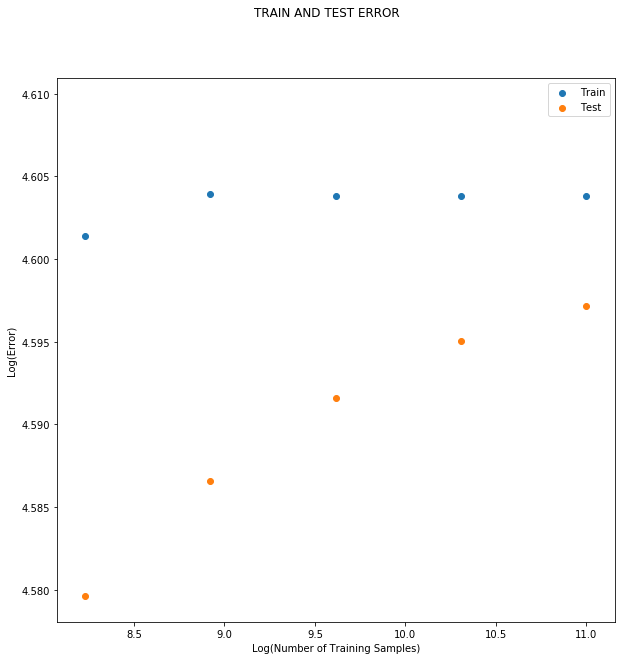

In [47]:
import numpy as np
import matplotlib.pyplot as plt


training_samples = [60000 * element for element in subsets]

def calculate_error(accuracy_values):
    error = []
    for val in accuracy_values:
        error.append(100. - val)
    return error

training_errors = calculate_error(training_errors)
test_errors = calculate_error(test_errors)

fig, axs = plt.subplots(figsize=(10, 10))
plt.scatter(np.log(training_samples), np.log(training_errors), label = "Train")
plt.scatter(np.log(training_samples), np.log(test_errors), label = "Test")

plt.xlabel("Log(Number of Training Samples)")
plt.ylabel("Log(Error)")
fig.suptitle("TRAIN AND TEST ERROR")
plt.legend()
plt.savefig("train_and_test_error.png")